## Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Define paths
data_dir = '/content/drive/MyDrive/Xpert_Scan'
train_path = f'{data_dir}/train'
test_path = f'{data_dir}/test'


Mounted at /content/drive


## Import Libraries

In [2]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt


## Load And Pre-Process Data

In [4]:
# Define parameters
img_size = (299, 299)  # InceptionV3 input size
batch_size = 32

# Load training and validation data
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

val_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size
)

# Load test data
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    image_size=img_size,
    batch_size=batch_size
)

# Apply InceptionV3 preprocessing
preprocess_input = tf.keras.applications.inception_v3.preprocess_input
train_data = train_data.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=tf.data.AUTOTUNE)
val_data = val_data.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=tf.data.AUTOTUNE)




Found 4365 files belonging to 6 classes.
Using 3492 files for training.
Found 4365 files belonging to 6 classes.
Using 873 files for validation.
Found 1876 files belonging to 6 classes.


## Visualize Data

Found 4365 files belonging to 6 classes.
Using 3492 files for training.
Class Names: ['COPD', 'Covid19', 'Lung_Metastasis', 'Normal', 'Pneumonia', 'Tuberculosis']


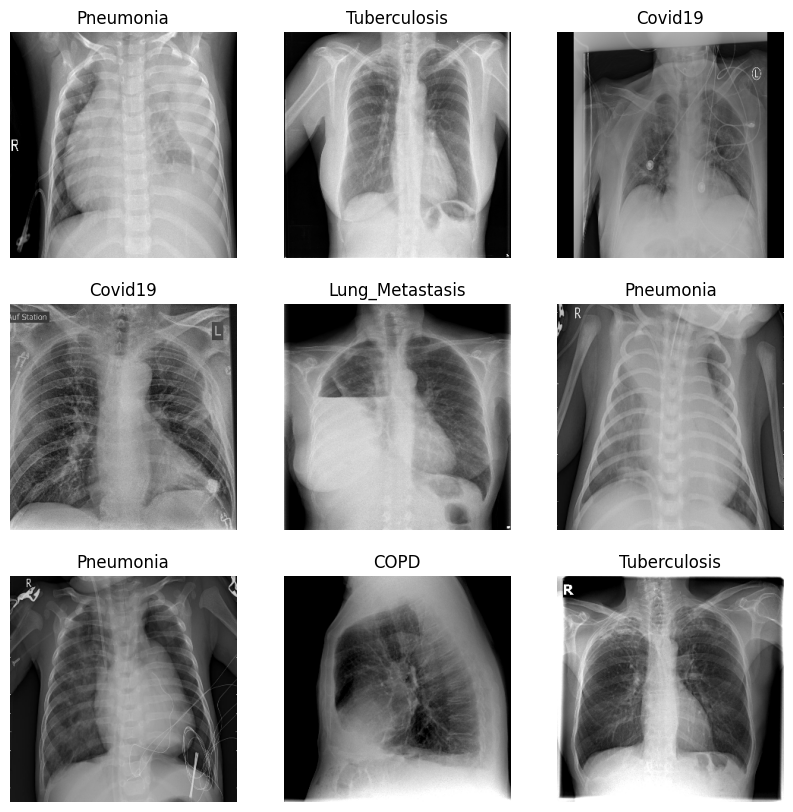

In [6]:
# Load original training data before preprocessing
original_train_data = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(299, 299),  # Match InceptionV3 input size
    batch_size=32
)

# Get class names from the dataset
class_names = original_train_data.class_names
print("Class Names:", class_names)
# Function to display sample images with labels
def display_sample_images(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):  # Take one batch
        num_images = min(9, images.shape[0])  # Ensure we don't exceed batch size
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))  # Convert tensor to image
            plt.title(class_names[int(labels[i].numpy())])  # Convert label tensor to integer
            plt.axis("off")

# Display images from the dataset
display_sample_images(original_train_data, class_names)


## Handle Class Imbalances

In [7]:
# Compute class weights
labels = np.concatenate([y.numpy() for _, y in train_data], axis=0).astype(int)
unique_classes = np.unique(labels)
class_weights = compute_class_weight(class_weight="balanced", classes=unique_classes, y=labels)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}


## Build The InceptionV3 Modal

In [8]:
# Load pre-trained InceptionV3 model
base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(299, 299, 3))
base_model.trainable = False  # Freeze the base model

# Build the classifier on top
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation="softmax")  # Output layer with class count
])

# Compile the model
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


## Define Callbacks

In [9]:
# Callback to save the model after each epoch
checkpoint_callback = ModelCheckpoint(
    filepath="inceptionv3_model_epoch_{epoch:02d}.keras",
    save_best_only=False,  # Save after every epoch
    save_weights_only=False,  # Save the entire model
    verbose=1
)

# Custom callback to display training progress
class TrainingProgressCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch + 1} complete.")
        print(f"Training Loss: {logs['loss']:.4f}, Training Accuracy: {logs['accuracy']:.4f}")
        print(f"Validation Loss: {logs['val_loss']:.4f}, Validation Accuracy: {logs['val_accuracy']:.4f}")


## Train Modals

In [10]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    class_weight=class_weight_dict,
    callbacks=[checkpoint_callback, TrainingProgressCallback()],
    verbose=1
)

print("Training completed. Models saved after each epoch.")


Epoch 1/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4346 - loss: 1.6333
Epoch 1: saving model to inceptionv3_model_epoch_01.keras
Epoch 1 complete.
Training Loss: 1.3758, Training Accuracy: 0.5149
Validation Loss: 1.0999, Validation Accuracy: 0.5189
110/110 ━━━━━━━━━━━━━━━━━━━━ 955s 9s/step - accuracy: 0.4353 - loss: 1.6310 - val_accuracy: 0.5189 - val_loss: 1.0999
Epoch 2/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5825 - loss: 1.1241
Epoch 2: saving model to inceptionv3_model_epoch_02.keras
Epoch 2 complete.
Training Loss: 1.0942, Training Accuracy: 0.6008
Validation Loss: 0.9697, Validation Accuracy: 0.5991
110/110 ━━━━━━━━━━━━━━━━━━━━ 900s 8s/step - accuracy: 0.5827 - loss: 1.1238 - val_accuracy: 0.5991 - val_loss: 0.9697
Epoch 3/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6363 - loss: 1.0139
Epoch 3: saving model to inceptionv3_model_epoch_03.keras
Epoch 3 complete.
Training Loss: 1.0054, Training Accuracy: 0.6340
Validation Loss: 0.9971, Val

## Save The Modals

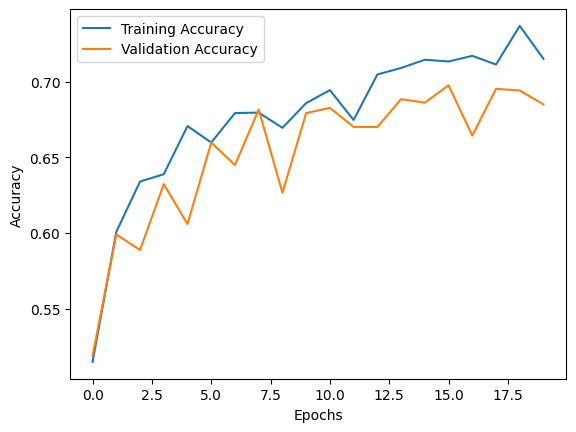

In [11]:
# Save the trained model
model.save('/content/drive/MyDrive/Xpert_Scan/InceptionNet.keras')

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
